# [Assignment 12](https://ovgu-ailab.github.io/idl2023/assignment12.html)
Adrian Bremer

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setup

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tfk = tf.keras
tfkl = tfk.layers

2024-01-23 13:20:26.334198: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-23 13:20:26.460771: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 13:20:26.460805: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-23 13:20:26.461220: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-23 13:20:26.521633: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-23 13:20:26.522611: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

## Load the mixed up CIFAR-data

In [4]:
data1 = np.load("drive/MyDrive/Colab Notebooks/cifar_attempts/data1.npz")
list(data1.keys())

['train_imgs', 'train_lbls', 'val_imgs', 'val_lbls', 'test_imgs', 'test_lbls']

In [2]:
data2 = np.load("drive/MyDrive/Colab Notebooks/cifar_attempts/data2.npz")
list(data2.keys())

FileNotFoundError: [Errno 2] No such file or directory: 'drive/MyDrive/Colab Notebooks/cifar_attempts/data2.npz'

In [6]:
data3 = np.load("drive/MyDrive/Colab Notebooks/cifar_attempts/data3.npz")
list(data3.keys())

['train_imgs', 'train_lbls', 'val_imgs', 'val_lbls', 'test_imgs', 'test_lbls']

In [7]:
data4 = np.load("drive/MyDrive/Colab Notebooks/cifar_attempts/data4.npz")
list(data4.keys())

['train_imgs', 'train_lbls', 'val_imgs', 'val_lbls', 'test_imgs', 'test_lbls']

## Inspect the data distributions

In [8]:
def inspect_data(data):
    _,ax = plt.subplots(2,3)
    ax[0,0].hist(data['train_lbls'], bins=10)
    ax[0,1].hist(data['val_lbls'], bins=10)
    ax[0,2].hist(data['test_lbls'], bins=10)
    ax[1,0].hist(data['train_imgs'].flatten(), bins=100)
    ax[1,1].hist(data['val_imgs'].flatten(), bins=100)
    ax[1,2].hist(data['test_imgs'].flatten(), bins=100)
    plt.show()

### data1
> Labels 3 and 7 are missing in training and validation set.  
> I assume that images from these classes are wrongly labeled

> Test set performance will probably be really bad because of this

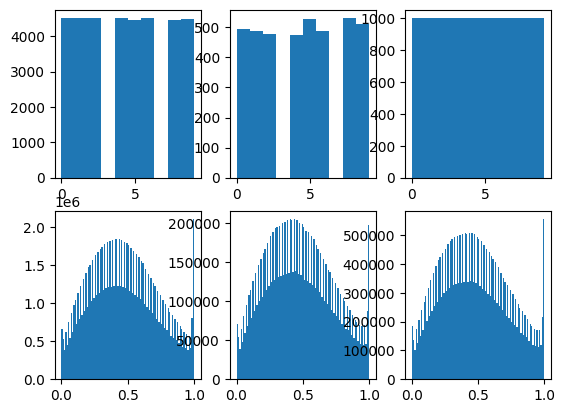

In [ ]:
inspect_data(data1)

### data2
> Train and test set are of equal distribution.  
> And the test set could actually be a subset of the training set (the distributions look identical)...

> I assume that the validation loss will be higher than the test loss.  

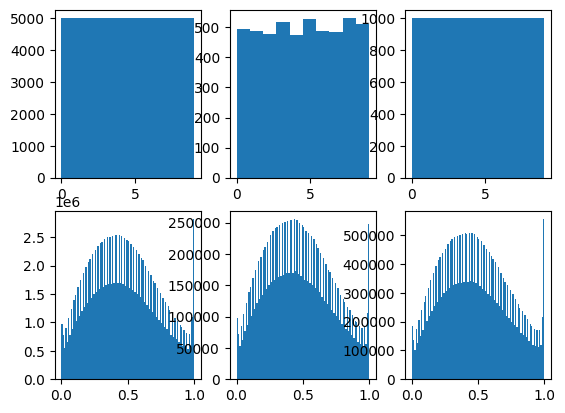

In [ ]:
inspect_data(data2)

### data3
> Isn't looking too bad, but the distributions of training and test set are again fairly close to each other...

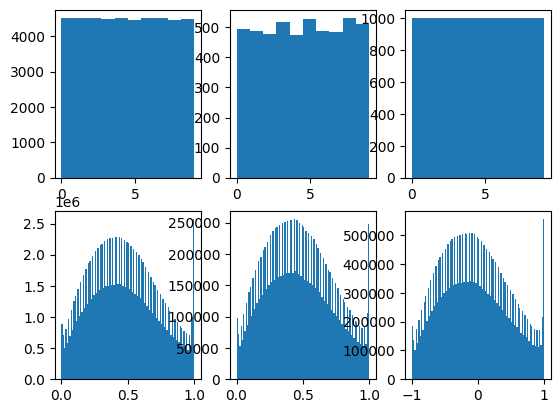

In [ ]:
inspect_data(data3)

### data4
> Training, validation and test set are of exactly the same distribution.
> Training and validation set have really similar pictures while the test set has the "normal" expected distribution.

> I assume that test performance will be bad and that there might be wrongly labeled images in training and validation set or that there aren't all images contained, since the pixel value distribution is so different.

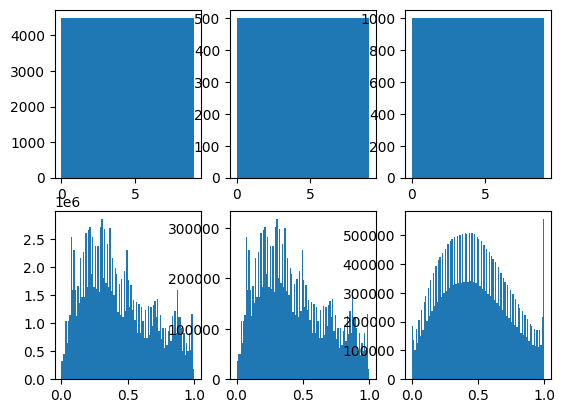

In [ ]:
inspect_data(data4)

## Creating datasets from the different CIFAR data

In [9]:
def create_datasets(data):
    data_train = tf.data.Dataset.from_tensor_slices((data['train_imgs'], data['train_lbls'])).shuffle(50000).batch(128).repeat()
    data_val = tf.data.Dataset.from_tensor_slices((data['val_imgs'], data['val_lbls'])).shuffle(5000).batch(128)
    data_test = tf.data.Dataset.from_tensor_slices((data['test_imgs'], data['test_lbls'])).shuffle(10000).batch(128)
    return (data_train, data_val, data_test)

data1_train, data1_val, data1_test = create_datasets(data1)
data2_train, data2_val, data2_test = create_datasets(data2)
data3_train, data3_val, data3_test = create_datasets(data3)
data4_train, data4_val, data4_test = create_datasets(data4)

## Building a model (Inception)

In [10]:
def inception_block(inputs, n_filters):
    conv1_1 = tf.keras.layers.Conv2D(n_filters, 1, padding="same")(inputs)

    conv1_3 = tf.keras.layers.Conv2D(n_filters, 1, padding="same")(inputs)
    conv1_3 = tf.keras.layers.Conv2D(n_filters, 3, padding="same")(conv1_3)

    conv1_5 = tf.keras.layers.Conv2D(n_filters, 1, padding="same")(inputs)
    conv1_5 = tf.keras.layers.Conv2D(n_filters, 5, padding="same")(conv1_5)

    pool1 = tf.keras.layers.MaxPool2D(3, 1, padding="same")(inputs)
    pool1 = tf.keras.layers.Conv2D(n_filters, 1, padding="same")(pool1)

    concat1 = tf.concat([conv1_1, conv1_3, conv1_5, pool1], axis=-1)
    concat1 = tf.keras.layers.BatchNormalization()(concat1)
    concat1 = tf.nn.relu(concat1)
    concat1 = tf.keras.layers.SpatialDropout2D(0.05)(concat1)

    return concat1

def inception_model(input_shape=(32, 32, 3), blocks_per_resolution=2, filters=[32,64,128]):
    inputs = tf.keras.layers.Input(input_shape)

    x = inputs
    # model with data augmentation
    # these layers do random changes during training,
    # and mostly do nothing during testing (except RandomCrop, which will do a center-crop)
    x = tf.keras.layers.RandomRotation(0.075)(x)
    x = tf.keras.layers.RandomCrop(28, 28)(x)
    x = tf.keras.layers.RandomFlip("horizontal")(x)
    x = tf.keras.layers.RandomContrast(0.1)(x)
    x = tf.keras.layers.RandomBrightness(0.1, [0., 1.])(x)

    for n_filters in filters:
        for block in range(blocks_per_resolution):
            x = inception_block(x, n_filters)
        # downsample
        x = tf.keras.layers.MaxPool2D(padding="same")(x)

    pooled = tf.keras.layers.GlobalAveragePooling2D()(x)
    logits = tf.keras.layers.Dense(10)(pooled)

    model = tf.keras.Model(inputs, logits, name="inception")

    return model

In [54]:
model = inception_model()
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "inception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 random_rotation_4 (RandomR  (None, 32, 32, 3)            0         ['input_5[0][0]']             
 otation)                                                                                         
                                                                                                  
 random_crop_4 (RandomCrop)  (None, 28, 28, 3)            0         ['random_rotation_4[0][0]']   
                                                                                                  
 random_flip_4 (RandomFlip)  (None, 28, 28, 3)            0         ['random_crop_4[0][0]'

## Training the model

In [33]:
def plot_image_grid_with_preds(model, imgs, lbls):
  N = int(np.sqrt(len(imgs)))

  preds = np.argmax(model(imgs[:(N*N)]), axis=1)

  fig,ax = plt.subplots(N,N)
  fig.set_figwidth(10)
  fig.set_figheight(10)
  for y in range(N):
    for x in range(N):
      idx = y*N+x
      ax[y,x].imshow(imgs[idx])
      ax[y,x].set_title(f'Pred: {preds[idx]}, True: {lbls[idx]}')
  plt.show()

### data1

> As expected train and validation set are really similar and the test loss / accuracy is way of the training loss / accuracy. The reason is, that the training and validation set are missing labels 3 and 7.  
> We can calculate: 0.66 (test_acc) = 0.8 (bc of 2 missing labels) * 0.83 (train/val_acc) = 0.664

> Therefore, the model is primarly getting the images of classes 3 and 7 wrong.

In [13]:
history1 = model.fit(
    data1_train,
    epochs=10,
    steps_per_epoch=256,
    validation_data=data1_val,
    callbacks=[
        tfk.callbacks.EarlyStopping(patience=2)
    ]
)

Epoch 1/10
256/256 [==============================] - 27s 105ms/step - loss: 1.3624 - accuracy: 0.4857 - val_loss: 2.0270 - val_accuracy: 0.3078
Epoch 2/10
256/256 [==============================] - 26s 103ms/step - loss: 1.0281 - accuracy: 0.6225 - val_loss: 1.0630 - val_accuracy: 0.6114
Epoch 3/10
256/256 [==============================] - 26s 101ms/step - loss: 0.8416 - accuracy: 0.6988 - val_loss: 0.9045 - val_accuracy: 0.6937
Epoch 4/10
256/256 [==============================] - 26s 100ms/step - loss: 0.7369 - accuracy: 0.7349 - val_loss: 0.5832 - val_accuracy: 0.8028
Epoch 5/10
256/256 [==============================] - 26s 102ms/step - loss: 0.6692 - accuracy: 0.7639 - val_loss: 0.4926 - val_accuracy: 0.8328
Epoch 6/10
256/256 [==============================] - 26s 100ms/step - loss: 0.6161 - accuracy: 0.7824 - val_loss: 0.4903 - val_accuracy: 0.8288
Epoch 7/10
256/256 [==============================] - 26s 100ms/step - loss: 0.5694 - accuracy: 0.7993 - val_loss: 0.4559 - val_ac

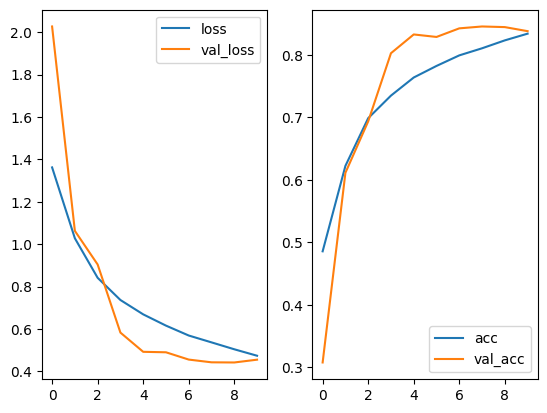

In [37]:
_,ax = plt.subplots(1,2)
ax[0].plot(history1.history['loss'], label='loss')
ax[0].plot(history1.history['val_loss'], label='val_loss')
ax[0].legend()
ax[1].plot(history1.history['accuracy'], label='acc')
ax[1].plot(history1.history['val_accuracy'], label='val_acc')
ax[1].legend()
plt.show()

In [40]:
model.evaluate(data1_test) # accedentially executed again... correct accuracy is 66%

79/79 [==============================] - 2s 27ms/step - loss: 0.6187 - accuracy: 0.7891


[0.6186689734458923, 0.7890999913215637]

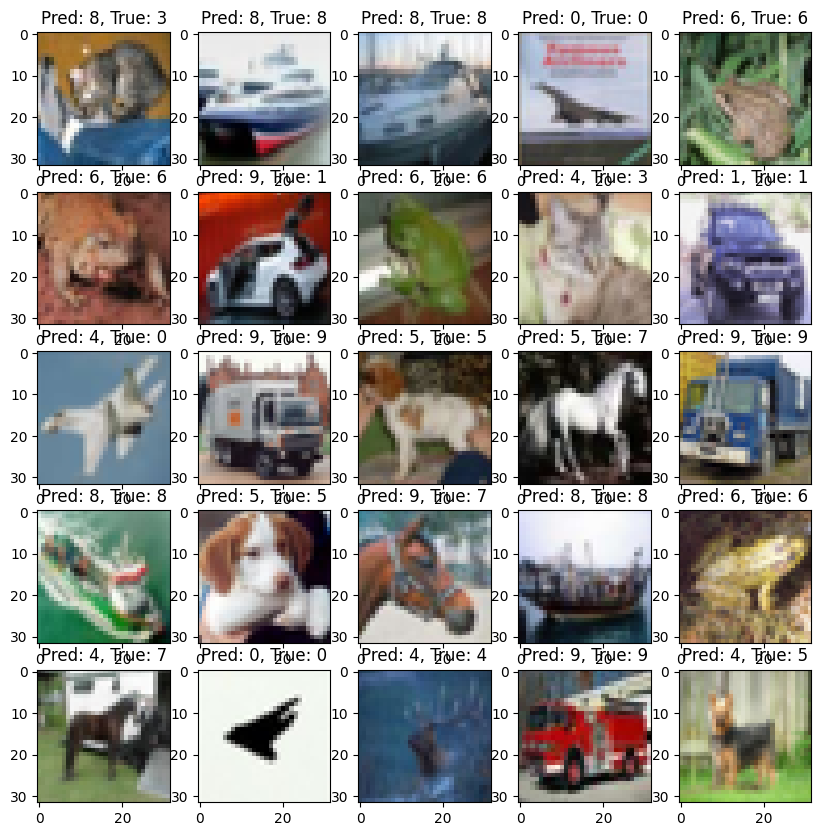

In [34]:
plot_image_grid_with_preds(model, data1['test_imgs'][:25], data1['test_lbls'])

### data 2
> Actually the validation loss is lower than the training and test loss, but training and test set are quite identical indeed.  
> It seems that the model has a problem with predicting ships (or planes (from previous executions)), but I can't find that there is a general problem with labels or so.

In [49]:
history2 = model.fit(
    data2_train,
    epochs=20,
    steps_per_epoch=256,
    validation_data=data2_val,
    callbacks=[
        tfk.callbacks.EarlyStopping(patience=2)
    ]
)

Epoch 1/20


KeyboardInterrupt: 

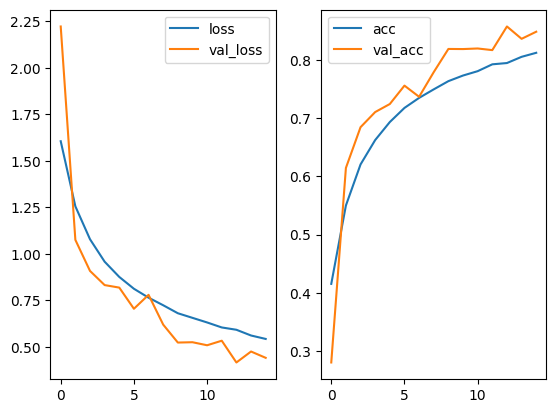

In [45]:
_,ax = plt.subplots(1,2)
ax[0].plot(history2.history['loss'], label='loss')
ax[0].plot(history2.history['val_loss'], label='val_loss')
ax[0].legend()
ax[1].plot(history2.history['accuracy'], label='acc')
ax[1].plot(history2.history['val_accuracy'], label='val_acc')
ax[1].legend()
plt.show()

In [46]:
model.evaluate(data2_test)

79/79 [==============================] - 2s 29ms/step - loss: 0.5243 - accuracy: 0.8264


[0.5242960453033447, 0.8263999819755554]

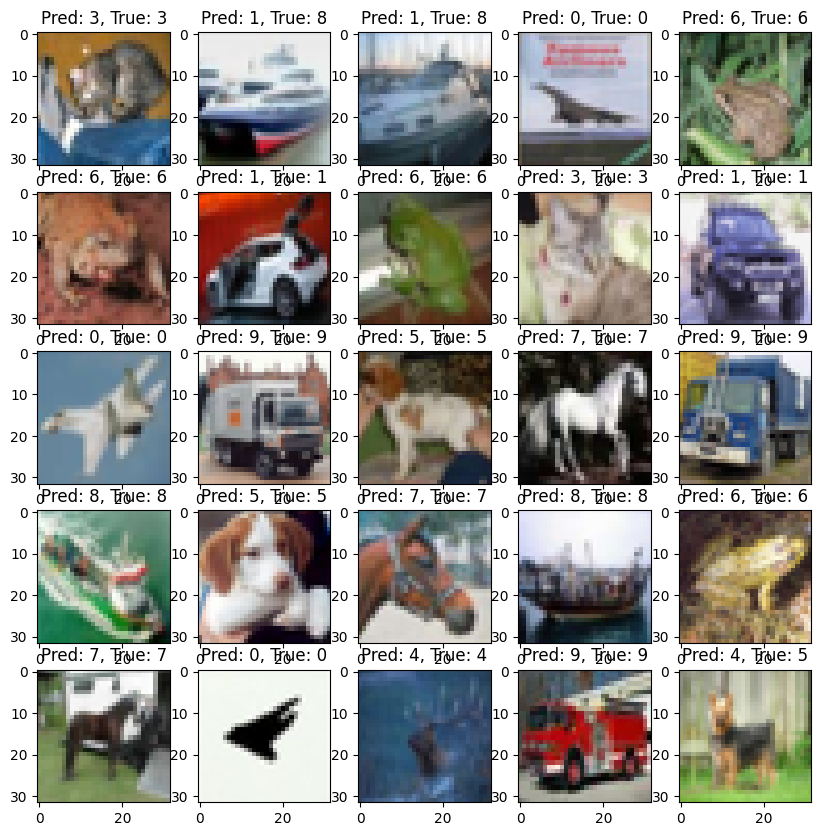

In [47]:
plot_image_grid_with_preds(model, data2['test_imgs'][:25], data2['test_lbls'][:25])

### data3
> The test data images have pixel values in range -1 to 1 -> Bad for test performance...

In [50]:
history3 = model.fit(
    data3_train,
    epochs=20,
    steps_per_epoch=256,
    validation_data=data3_val,
    callbacks=[
        tfk.callbacks.EarlyStopping(patience=2)
    ]
)

Epoch 1/20
256/256 [==============================] - 27s 106ms/step - loss: 1.5910 - accuracy: 0.4192 - val_loss: 2.2412 - val_accuracy: 0.3088
Epoch 2/20
256/256 [==============================] - 29s 114ms/step - loss: 1.2478 - accuracy: 0.5512 - val_loss: 1.2026 - val_accuracy: 0.5750
Epoch 3/20
256/256 [==============================] - 27s 107ms/step - loss: 1.0677 - accuracy: 0.6205 - val_loss: 0.9149 - val_accuracy: 0.6812
Epoch 4/20
256/256 [==============================] - 26s 101ms/step - loss: 0.9543 - accuracy: 0.6643 - val_loss: 0.8530 - val_accuracy: 0.7086
Epoch 5/20
256/256 [==============================] - 26s 101ms/step - loss: 0.8664 - accuracy: 0.6967 - val_loss: 0.7913 - val_accuracy: 0.7286
Epoch 6/20
256/256 [==============================] - 26s 102ms/step - loss: 0.7948 - accuracy: 0.7223 - val_loss: 0.7280 - val_accuracy: 0.7462
Epoch 7/20
256/256 [==============================] - 26s 102ms/step - loss: 0.7564 - accuracy: 0.7387 - val_loss: 0.7540 - val_ac

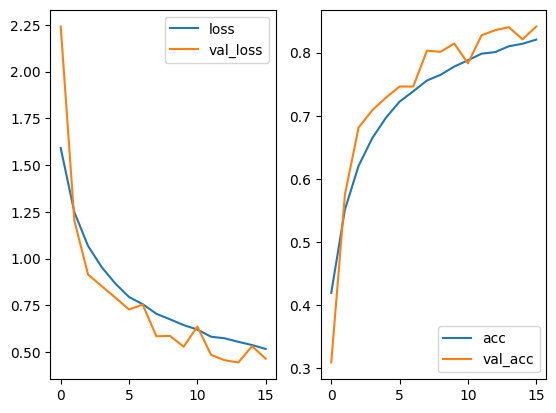

In [51]:
_,ax = plt.subplots(1,2)
ax[0].plot(history3.history['loss'], label='loss')
ax[0].plot(history3.history['val_loss'], label='val_loss')
ax[0].legend()
ax[1].plot(history3.history['accuracy'], label='acc')
ax[1].plot(history3.history['val_accuracy'], label='val_acc')
ax[1].legend()
plt.show()

In [52]:
model.evaluate(data3_test)

79/79 [==============================] - 2s 27ms/step - loss: 0.9277 - accuracy: 0.6899


[0.9277433753013611, 0.6898999810218811]

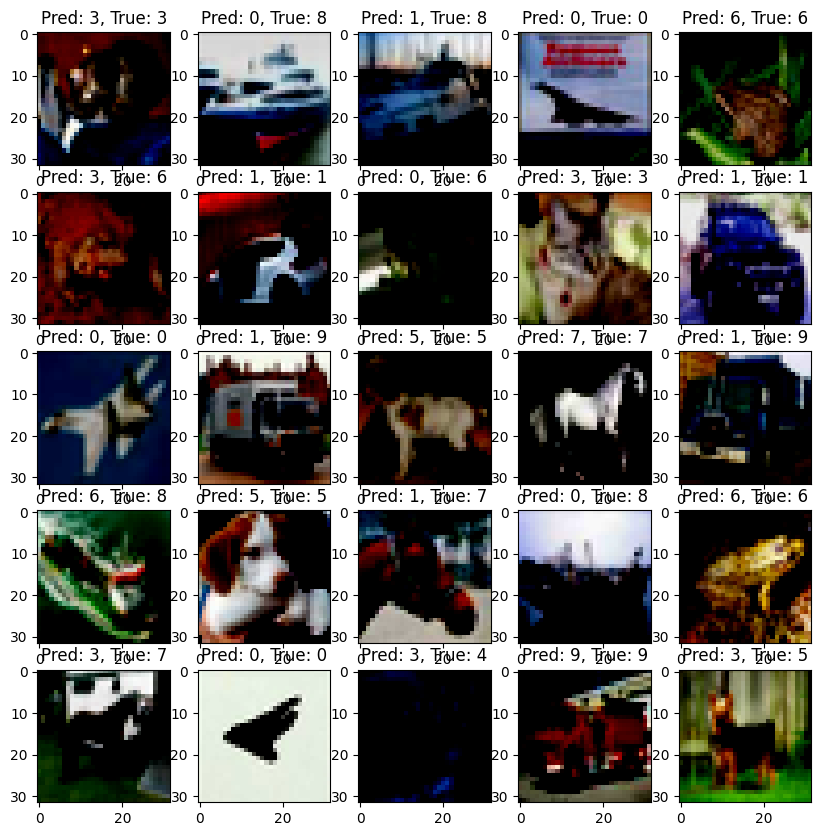

In [53]:
plot_image_grid_with_preds(model, data3['test_imgs'][:25], data3['test_lbls'][:25])

### data4
> Every class in train and validation consist of one image each -> super easy to reach 100% accuracy

In [55]:
history4 = model.fit(
    data4_train,
    epochs=20,
    steps_per_epoch=256,
    validation_data=data4_val,
    callbacks=[
        tfk.callbacks.EarlyStopping(patience=2)
    ]
)

Epoch 1/20
256/256 [==============================] - 42s 109ms/step - loss: 0.0209 - accuracy: 0.9944 - val_loss: 6.6242 - val_accuracy: 0.3000
Epoch 2/20
256/256 [==============================] - 26s 103ms/step - loss: 3.6072e-04 - accuracy: 0.9999 - val_loss: 4.6094e-04 - val_accuracy: 1.0000
Epoch 3/20
256/256 [==============================] - 28s 108ms/step - loss: 7.9727e-05 - accuracy: 1.0000 - val_loss: 1.2398e-06 - val_accuracy: 1.0000
Epoch 4/20
256/256 [==============================] - 26s 103ms/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 2.5712e-05 - val_accuracy: 1.0000
Epoch 5/20
256/256 [==============================] - 26s 101ms/step - loss: 0.0021 - accuracy: 0.9994 - val_loss: 2.8372e-06 - val_accuracy: 1.0000


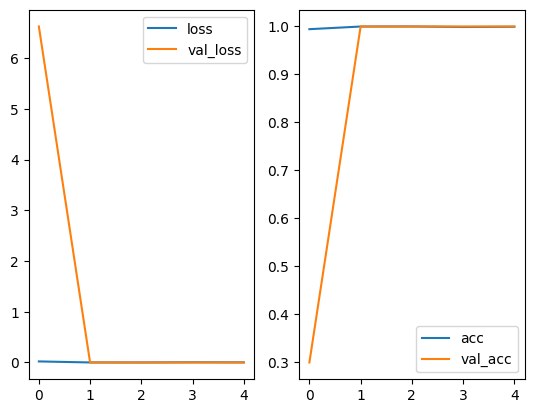

In [56]:
_,ax = plt.subplots(1,2)
ax[0].plot(history4.history['loss'], label='loss')
ax[0].plot(history4.history['val_loss'], label='val_loss')
ax[0].legend()
ax[1].plot(history4.history['accuracy'], label='acc')
ax[1].plot(history4.history['val_accuracy'], label='val_acc')
ax[1].legend()
plt.show()

In [57]:
model.evaluate(data4_test)

79/79 [==============================] - 2s 28ms/step - loss: 7.9588 - accuracy: 0.1599


[7.958767890930176, 0.1598999947309494]

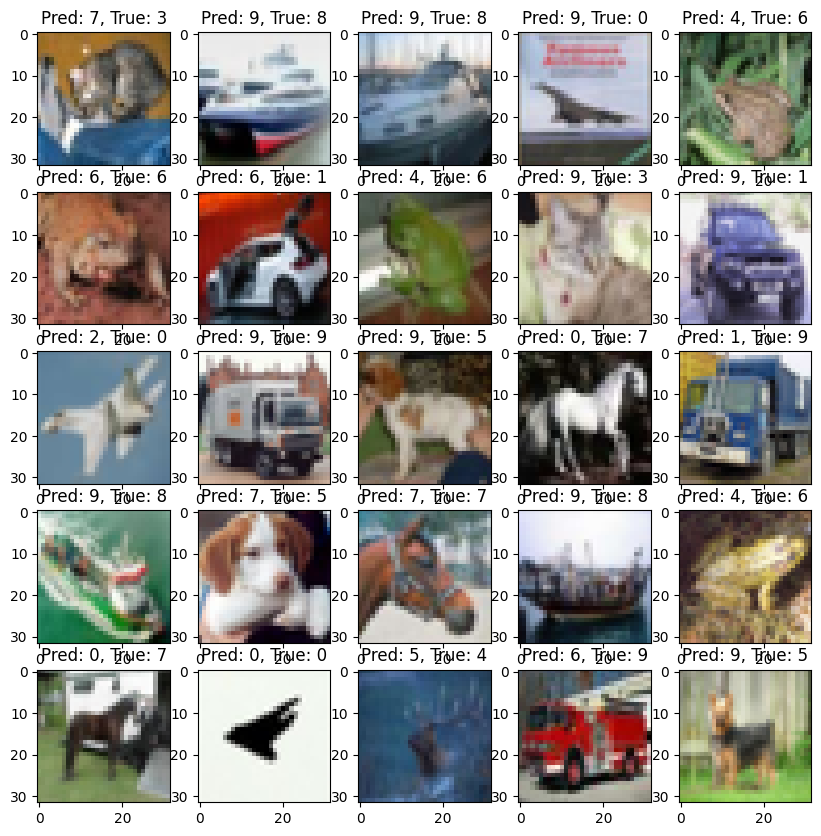

In [58]:
plot_image_grid_with_preds(model, data4['test_imgs'][:25], data4['test_lbls'][:25])

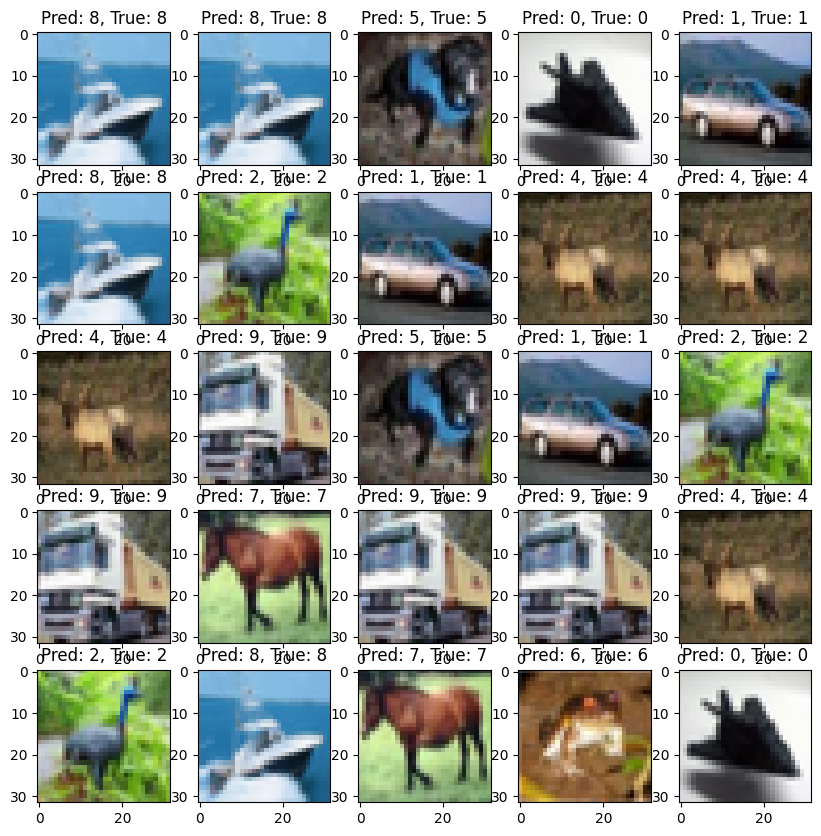

In [59]:
plot_image_grid_with_preds(model, data4['train_imgs'][:25], data4['train_lbls'][:25])

## Further inspection

### data 2

In [3]:
data2 = np.load("cifar_attempts/data2.npz")

In [4]:
print(np.shape(data2['train_lbls']), np.shape(data2['train_imgs']))
print(np.shape(data2['val_lbls']), np.shape(data2['val_imgs']))
print(np.shape(data2['test_lbls']), np.shape(data2['test_imgs']))

(50000,) (50000, 32, 32, 3)
(5000,) (5000, 32, 32, 3)
(10000,) (10000, 32, 32, 3)


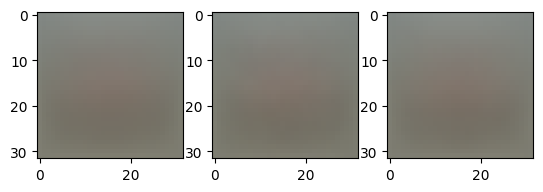

In [7]:
mean_train_img = np.mean(data2['train_imgs'], axis=0)
mean_val_img = np.mean(data2['val_imgs'], axis=0)
mean_test_img = np.mean(data2['test_imgs'], axis=0)

_,ax = plt.subplots(1,3)
ax[0].imshow(mean_train_img)
ax[1].imshow(mean_val_img)
ax[2].imshow(mean_test_img)
plt.show()

In [8]:
print(np.max(np.abs(mean_train_img - mean_val_img)))
print(np.max(np.abs(mean_train_img - mean_test_img)))
print(np.max(np.abs(mean_val_img - mean_test_img)))

0.010571539
0.011518776
0.015013456


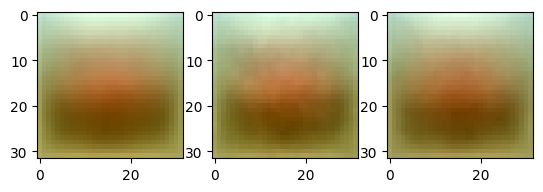

In [10]:
def min_max_scaling(img):
    mini = np.min(img)
    maxi = np.max(img)
    return (img - mini) / (maxi-mini)

sc_m_tr = min_max_scaling(mean_train_img)
sc_m_va = min_max_scaling(mean_val_img)
sc_m_te = min_max_scaling(mean_test_img)

_,ax = plt.subplots(1,3)
ax[0].imshow(sc_m_tr)
ax[1].imshow(sc_m_va)
ax[2].imshow(sc_m_te)
plt.show()

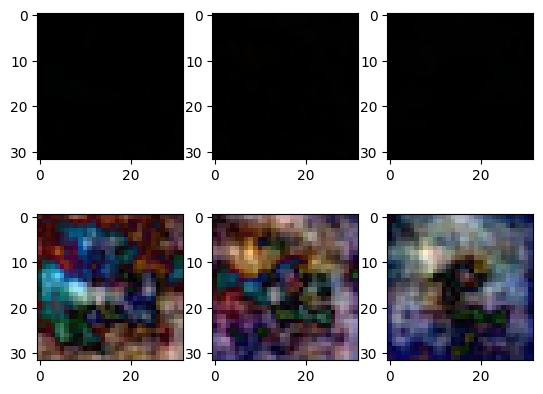

In [12]:
diff_tr_va = np.abs(mean_train_img - mean_val_img)
diff_te_va = np.abs(mean_test_img - mean_val_img)
diff_tr_te = np.abs(mean_train_img - mean_test_img)


sc_diff_tr_va = min_max_scaling(np.abs(mean_train_img - mean_val_img))
sc_diff_te_va = min_max_scaling(np.abs(mean_test_img - mean_val_img))
sc_diff_tr_te = min_max_scaling(np.abs(mean_train_img - mean_test_img))

_,ax = plt.subplots(2,3)
ax[0,0].imshow(diff_tr_va)
ax[0,1].imshow(diff_te_va)
ax[0,2].imshow(diff_tr_te)
ax[1,0].imshow(sc_diff_tr_va)
ax[1,1].imshow(sc_diff_te_va)
ax[1,2].imshow(sc_diff_tr_te)
plt.show()

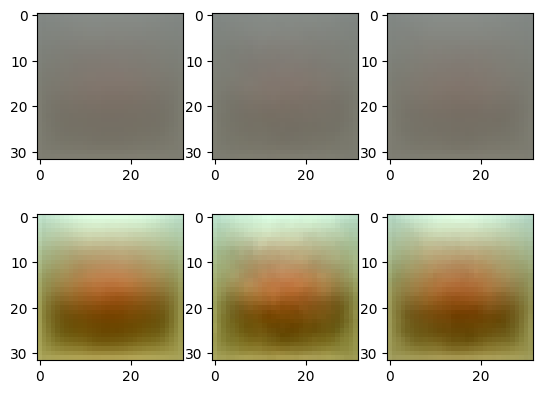

In [14]:
variance_train_img = np.mean(data2['train_imgs'], axis=0)
variance_val_img = np.mean(data2['val_imgs'], axis=0)
variance_test_img = np.mean(data2['test_imgs'], axis=0)

sc_variance_train_img = min_max_scaling(np.mean(data2['train_imgs'], axis=0))
sc_variance_val_img = min_max_scaling(np.mean(data2['val_imgs'], axis=0))
sc_variance_test_img = min_max_scaling(np.mean(data2['test_imgs'], axis=0))

_,ax = plt.subplots(2,3)
ax[0,0].imshow(variance_train_img)
ax[0,1].imshow(variance_val_img)
ax[0,2].imshow(variance_test_img)
ax[1,0].imshow(sc_variance_train_img)
ax[1,1].imshow(sc_variance_val_img)
ax[1,2].imshow(sc_variance_test_img)

plt.show()

> test set looks a little bit like an average of train and validation set, but all are very similar

> the sets are probably not disjunct -> test loss and accuracy are really good (nearly too good)